https://github.com/sgugger/Adam-experiments

In [1]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10")

In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [3]:
sz = 32
bs = 128

m = wrn_22()
base_lr = 3e-3
lr_div = 10
wd = 0.1
cyc_len = 18     # lenght of the cycle expressed in epochs
ann_len = 0.075   # length of the annealing phase expressed as a fraction of cycle_len

moms = (0.95,0.85)
beta2=0.99

phase_lengths = [cyc_len * (1-ann_len) / 2, cyc_len * (1-ann_len) / 2, cyc_len * ann_len]; phase_lengths

[8.325000000000001, 8.325000000000001, 1.3499999999999999]

In [4]:
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomCrop(sz), RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
learn = ConvLearner.from_model_data(m, data)
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]

In [6]:
def adam(params): return optim.Adam(params, betas=(moms[0], beta2))
learn.opt_fn = adam

In [7]:
training_phases = [
    TrainingPhase(phase_lengths[0], adam, lr=(base_lr/lr_div, base_lr), lr_decay=DecayType.LINEAR,
              momentum=moms,  momentum_decay=DecayType.LINEAR, wds=wd, wd_loss=False),
    TrainingPhase(phase_lengths[1], adam, lr=(base_lr, base_lr/lr_div), lr_decay=DecayType.LINEAR,
              momentum=(moms[1], moms[0]), momentum_decay=DecayType.LINEAR, wds=wd, wd_loss=False),
    TrainingPhase(phase_lengths[2], adam, lr=(base_lr/lr_div, base_lr/(lr_div*100)), lr_decay=DecayType.LINEAR,
              momentum=moms[0], wds=wd, wd_loss=False)
]

In [8]:
%time learn.fit_opt_sched(training_phases)

epoch      trn_loss   val_loss   accuracy                   
    0      1.112043   1.345067   0.5328    
    1      0.831825   0.942278   0.6832                      
    2      0.686862   0.82179    0.7301                      
    3      0.588      0.666054   0.7756                      
    4      0.547755   0.675355   0.7729                      
    5      0.489622   0.846058   0.7413                      
    6      0.470558   0.732024   0.758                       
    7      0.441935   0.556813   0.8094                      
    8      0.407183   0.53978    0.817                       
    9      0.368785   0.427846   0.8583                      
    10     0.310193   0.355229   0.878                       
    11     0.261422   0.379379   0.8748                      
    12     0.209452   0.307924   0.897                       
    13     0.189456   0.263173   0.9136                      
    14     0.140466   0.246966   0.9203                      
    15     0.099081   0.243

[array([0.2096]), 0.9376]

In [9]:
preds, targs = learn.TTA()
probs = np.exp(preds)/np.exp(preds).sum(2)[:,:,None]
probs = np.mean(probs,0)
acc = learn.metrics[0](V(probs), V(targs)).data[0]
loss = learn.crit(V(np.log(probs)), V(targs)).data[0]
f'Final loss: {loss}, Final accuracy: {acc}'

'Final loss: 0.176131471991539, Final accuracy: 0.9424999952316284'

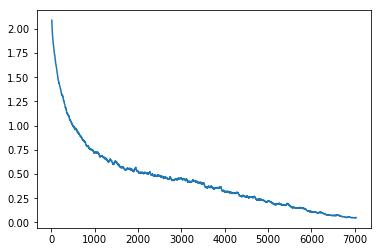

In [10]:
learn.sched.plot_loss()

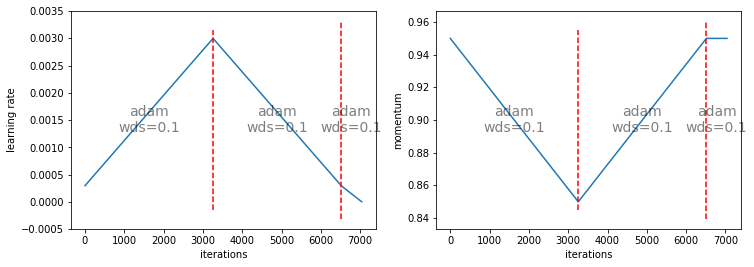

In [11]:
learn.sched.plot_lr()

In [15]:
learn.save('cifar10_adamw_aws_p2_xlarge')